<a href="https://colab.research.google.com/github/YuxuanMa1031/ENGI9867_T5/blob/main/BARTTestHuggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setup Environment and import Libraries

In [10]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets -U
!pip install rouge_score
!pip install evaluate


import torch
import transformers
import accelerate
import evaluate
from datasets import load_dataset, load_metric
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Load BART Model and Tokenizer

In [11]:
# Load pre-trained BART model and tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)



Step 3: Loading datasets and data preprocessing

In [ ]:
from datasets import load_dataset

# Example dataset: CNN/DailyMail
dataset = load_dataset('cnn_dailymail', '3.0.0')
articles = dataset['test']['article']  # Use test set articles

# 加载预训练的BART模型和tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# 加载CNN/DailyMail数据集
dataset = load_dataset('cnn_dailymail', '3.0.0')

# 数据预处理
# 对数据集进行标记
def tokenize_function(examples):
    inputs = tokenizer(examples['article'], max_length=512, truncation=True, padding='max_length')
    outputs = tokenizer(examples['highlights'], max_length=128, truncation=True, padding='max_length')
    inputs['labels'] = outputs['input_ids']
    return inputs
    # 应用标记函数到数据集
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["article", "highlights", "id"])

In [ ]:
def show_examples(dataset, model, tokenizer, num_examples=3):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for i in range(num_examples):
        article = dataset['test'][i]['article']
        inputs = tokenizer(article, max_length=512, return_tensors='pt', truncation=True)
        inputs = inputs.to(device)
        summary_ids = model.generate(inputs['input_ids'], max_length=128, min_length=30, length_penalty=2.0, num_beams=2, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(f"Article {i+1}: {article[:500]}...")  # 仅显示文章的前500个字符
        print(f"Summary {i+1}: {summary}")
        print("\n")

# 展示前三篇文章和摘要
show_examples(dataset, model, tokenizer)

Article 1: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, includin...
Summary 1: Palestinian Authority becomes 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in Palestinian territories. Israel and the United States opposed the Palestinians' efforts to join the body.


Article 2: (CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing an

Transformers version: 4.42.4
Accelerate version: 0.32.1


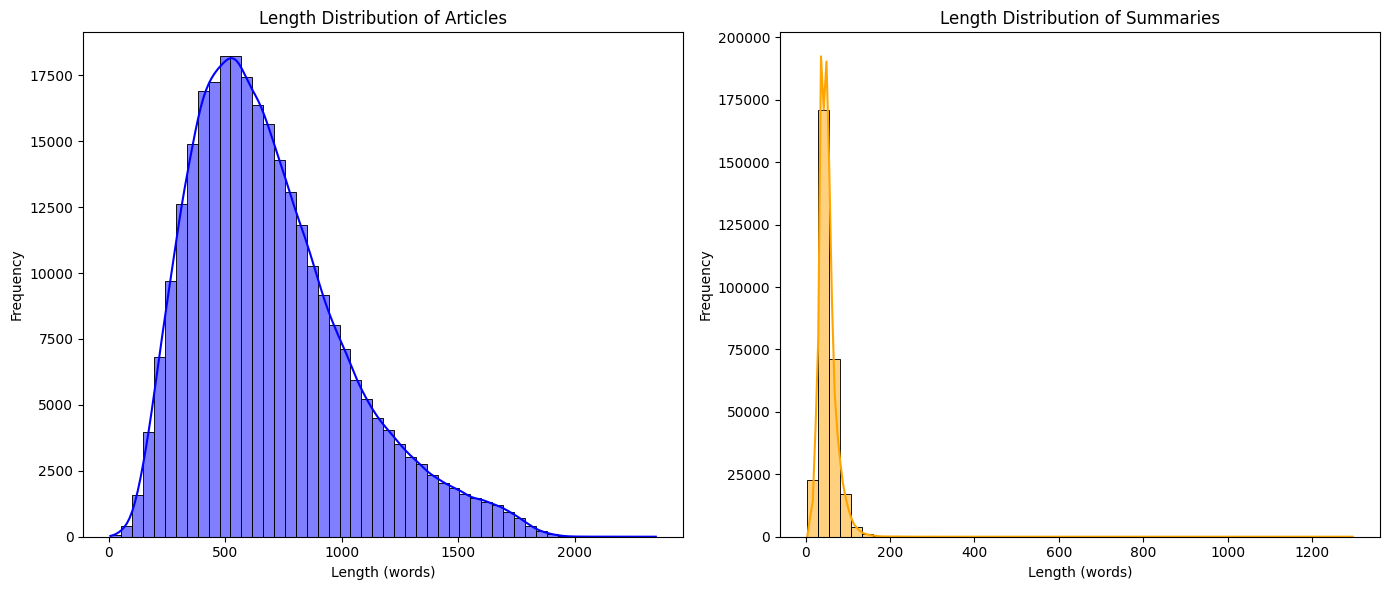

In [ ]:
import torch
from datasets import load_dataset, load_metric
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns

# 确认库的版本
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

# 加载预训练的BART模型和tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# 加载CNN/DailyMail数据集
dataset = load_dataset('cnn_dailymail', '3.0.0')

# 数据预处理
def tokenize_function(examples):
    inputs = tokenizer(examples['article'], max_length=512, truncation=True, padding='max_length')
    outputs = tokenizer(examples['highlights'], max_length=128, truncation=True, padding='max_length')
    inputs['labels'] = outputs['input_ids']
    return inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["article", "highlights", "id"])

# 可视化文章和摘要的长度分布
def plot_length_distribution(texts, title, color):
    lengths = [len(text.split()) for text in texts]
    sns.histplot(lengths, bins=50, kde=True, color=color)
    plt.title(f'Length Distribution of {title}')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')

# 设置图形大小
plt.figure(figsize=(14, 6))

# 绘制文章长度分布
plt.subplot(1, 2, 1)  # 一行两列中的第一个子图
plot_length_distribution(dataset['train']['article'], 'Articles', 'blue')

# 绘制摘要长度分布
plt.subplot(1, 2, 2)  # 一行两列中的第二个子图
plot_length_distribution(dataset['train']['highlights'], 'Summaries', 'orange')

# 展示图形
plt.tight_layout()
plt.show()

# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,  # 使用1个epoch进行快速测试
    weight_decay=0.01,
)

# 使用 DataCollatorWithPadding 进行数据填充
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'].select(range(1000)),  # 仅使用前1000个样本进行快速测试
    eval_dataset=tokenized_dataset['validation'].select(range(200)),  # 仅使用前200个样本进行
)

In [8]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,  # 使用1个epoch进行快速测试
    weight_decay=0.01,
)


# 使用 DataCollatorWithPadding 进行数据填充
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'].select(range(100)),  # 仅使用前1000个样本进行快速测试
    eval_dataset=tokenized_dataset['validation'].select(range(100)),  # 仅使用前200个样本进行快速测试
    data_collator=data_collator
)

# 微调模型
trainer.train()


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,No log,1.113368


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=50, training_loss=2.6858975219726564, metrics={'train_runtime': 2545.5605, 'train_samples_per_second': 0.039, 'train_steps_per_second': 0.02, 'total_flos': 108355230105600.0, 'train_loss': 2.6858975219726564, 'epoch': 1.0})

Step 6: Evaluation model

In [9]:
# 评估
rouge = load_metric('rouge', trust_remote_code=True)

def evaluate_model(model, tokenizer, dataset, num_samples=100, device='cuda'):
    model.eval()
    model.to(device)
    summaries = []
    references = []
    for sample in dataset.select(range(num_samples)):
        input_ids = tokenizer.encode(sample['article'], return_tensors='pt', max_length=512, truncation=True).to(device)
        summary_ids = model.generate(input_ids, max_length=128, min_length=30, length_penalty=2.0, num_beams=2, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        references.append(sample['highlights'])
    return rouge.compute(predictions=summaries, references=references)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bart_rouge_scores = evaluate_model(model, tokenizer, dataset['test'], num_samples=100, device=device)
print("BART ROUGE Scores:", bart_rouge_scores)


<ipython-input-9-fd40d24b07c2>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge', trust_remote_code=True)


BART ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.2994480867661343, recall=0.40696251824104335, fmeasure=0.3402117596468341), mid=Score(precision=0.32413848072510365, recall=0.4358380667701521, fmeasure=0.361868464918806), high=Score(precision=0.3464753161811193, recall=0.4631227876199535, fmeasure=0.38318290766228125)), 'rouge2': AggregateScore(low=Score(precision=0.12085864914865052, recall=0.1614314288372931, fmeasure=0.13502875966732733), mid=Score(precision=0.1391076366392544, recall=0.1857214923470149, fmeasure=0.1549828078619811), high=Score(precision=0.15830175394609855, recall=0.21008939576490665, fmeasure=0.17486887408750185)), 'rougeL': AggregateScore(low=Score(precision=0.2197753044019913, recall=0.2988768827955028, fmeasure=0.24811624356373604), mid=Score(precision=0.23895573851391227, recall=0.3214621610859784, fmeasure=0.2665687637703108), high=Score(precision=0.2582546855375484, recall=0.34508538628021485, fmeasure=0.28492169876212453)), 'rougeLsum': Ag

In [15]:
def evaluate_model_and_calculate_metrics(model, tokenizer, dataset, num_samples=50, device='cuda'):
    model.eval()
    model.to(device)
    summaries = []
    references = []

    for sample in dataset.select(range(num_samples)):
        input_ids = tokenizer.encode(sample['article'], return_tensors='pt', max_length=512, truncation=True).to(device)
        summary_ids = model.generate(input_ids, max_length=128, min_length=30, length_penalty=1.0, num_beams=2, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        references.append(sample['highlights'])

    # 计算长度的 MAE 和 RMSE
    summaries_lengths = [len(summary.split()) for summary in summaries]
    references_lengths = [len(reference.split()) for reference in references]
    mae = mean_absolute_error(references_lengths, summaries_lengths)
    rmse = mean_squared_error(references_lengths, summaries_lengths, squared=False)

    # 计算 ROUGE 分数
    rouge_results = rouge.compute(predictions=summaries, references=references)

    # 为了计算分类指标，我们将句子对齐，并确保长度一致
    aligned_summaries = []
    aligned_references = []

    for summary, reference in zip(summaries, references):
        summary_tokens = summary.split()
        reference_tokens = reference.split()
        min_length = min(len(summary_tokens), len(reference_tokens))
        aligned_summaries.extend(summary_tokens[:min_length])
        aligned_references.extend(reference_tokens[:min_length])

    # 计算分类指标
    precision = precision_score(aligned_references, aligned_summaries, average='weighted', zero_division=1)
    recall = recall_score(aligned_references, aligned_summaries, average='weighted', zero_division=1)
    f1 = f1_score(aligned_references, aligned_summaries, average='weighted', zero_division=1)
    accuracy = accuracy_score(aligned_references, aligned_summaries)
    conf_matrix = confusion_matrix(aligned_references, aligned_summaries)

    # 计算 TPR 和 FPR
    # 由于混淆矩阵可能有多个类别，我们只计算二分类的 TPR 和 FPR
    if conf_matrix.shape[0] == 2:
        tn, fp, fn, tp = conf_matrix.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
    else:
        tpr = fpr = None

    return summaries, references, rouge_results, mae, rmse, precision, recall, f1, accuracy, conf_matrix, tpr, fpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 评估BART模型并计算所有指标
bart_summaries, bart_references, bart_rouge_scores, bart_mae, bart_rmse, bart_precision, bart_recall, bart_f1, bart_accuracy, bart_conf_matrix, bart_tpr, bart_fpr = evaluate_model_and_calculate_metrics(model, tokenizer, dataset['test'], num_samples=50, device=device)

print("BART ROUGE Scores:", bart_rouge_scores)
print("BART MAE:", bart_mae)
print("BART RMSE:", bart_rmse)
print("BART Precision:", bart_precision)
print("BART Recall:", bart_recall)
print("BART F1 Score:", bart_f1)
print("BART Accuracy:", bart_accuracy)
print("BART Confusion Matrix:\n", bart_conf_matrix)
print("BART True Positive Rate (TPR):", bart_tpr)
print("BART False Positive Rate (FPR):", bart_fpr)


BART ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.3232069681956512, recall=0.32847796042224364, fmeasure=0.3175531311437878), mid=Score(precision=0.3707400208469517, recall=0.3726692697796037, fmeasure=0.3600894227092966), high=Score(precision=0.42186226170010677, recall=0.42356132565475907, fmeasure=0.40740206912129817)), 'rouge2': AggregateScore(low=Score(precision=0.134753899631083, recall=0.1365682304866882, fmeasure=0.13084728480214838), mid=Score(precision=0.17650043265697876, recall=0.18504130048661788, fmeasure=0.17552995163345608), high=Score(precision=0.22886668364803853, recall=0.24134093128276635, fmeasure=0.22797016962708982)), 'rougeL': AggregateScore(low=Score(precision=0.2521776452540512, recall=0.2545075177037836, fmeasure=0.24610775067658666), mid=Score(precision=0.2974273021230094, recall=0.3026638237957932, fmeasure=0.29039077858447526), high=Score(precision=0.3480751882140838, recall=0.3506409081617194, fmeasure=0.3386239182112657)), 'rougeLsum': A

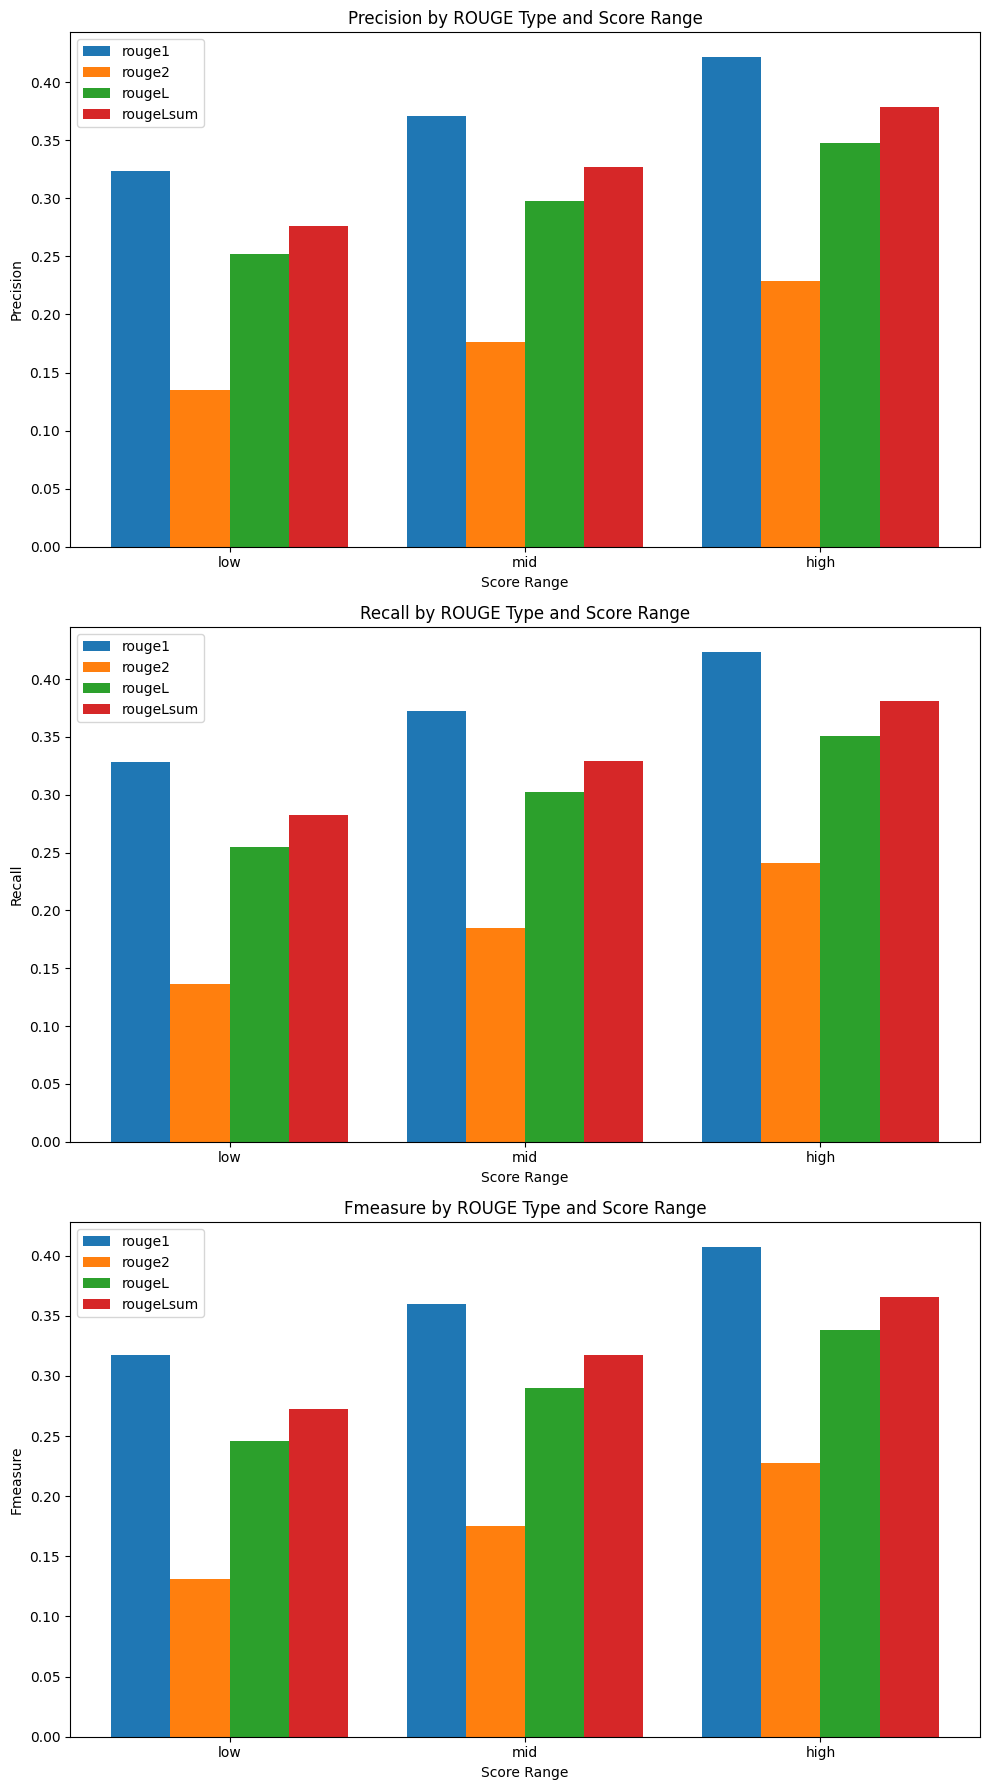

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ROUGE scores data
rouge_scores = {
    'rouge1': {
        'low': {'precision': 0.3232, 'recall': 0.3285, 'fmeasure': 0.3176},
        'mid': {'precision': 0.3707, 'recall': 0.3727, 'fmeasure': 0.3601},
        'high': {'precision': 0.4219, 'recall': 0.4236, 'fmeasure': 0.4074},
    },
    'rouge2': {
        'low': {'precision': 0.1348, 'recall': 0.1366, 'fmeasure': 0.1308},
        'mid': {'precision': 0.1765, 'recall': 0.1850, 'fmeasure': 0.1755},
        'high': {'precision': 0.2289, 'recall': 0.2413, 'fmeasure': 0.2280},
    },
    'rougeL': {
        'low': {'precision': 0.2522, 'recall': 0.2545, 'fmeasure': 0.2461},
        'mid': {'precision': 0.2974, 'recall': 0.3027, 'fmeasure': 0.2904},
        'high': {'precision': 0.3481, 'recall': 0.3506, 'fmeasure': 0.3386},
    },
    'rougeLsum': {
        'low': {'precision': 0.2764, 'recall': 0.2826, 'fmeasure': 0.2725},
        'mid': {'precision': 0.3266, 'recall': 0.3294, 'fmeasure': 0.3178},
        'high': {'precision': 0.3785, 'recall': 0.3809, 'fmeasure': 0.3657},
    }
}

# Extracting data
metrics = ['precision', 'recall', 'fmeasure']
scores = ['low', 'mid', 'high']
rouge_types = list(rouge_scores.keys())

# Creating data for bar chart
data = {}
for metric in metrics:
    data[metric] = {rouge_type: [rouge_scores[rouge_type][score][metric] for score in scores] for rouge_type in rouge_types}

# Bar chart settings
x = np.arange(len(scores))  # label locations
width = 0.2  # bar width

# Creating subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
for i, metric in enumerate(metrics):
    ax = axs[i]
    for j, rouge_type in enumerate(rouge_types):
        ax.bar(x + j*width, data[metric][rouge_type], width, label=rouge_type)

    ax.set_xlabel('Score Range')
    ax.set_ylabel(f'{metric.capitalize()}')
    ax.set_title(f'{metric.capitalize()} by ROUGE Type and Score Range')
    ax.set_xticks(x + width * (len(rouge_types) - 1) / 2)
    ax.set_xticklabels(scores)
    ax.legend()

plt.tight_layout()
plt.show()
